# Домашнее задание 4.

Выполнил Гончаров Алексей Владимирович, 274 группа МФТИ, ФУПМ
Задание:
Соревнование Quora. Необходимо определить дубликаты вопросов на сайте Quora. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pal = sns.color_palette()

In [2]:
data = pd.read_csv('train.csv')

### 1. Статистика по предложениям

- Посчитаем кол-во объектов, долю повторяющихся объектов
- Посчитаем распределение по длине вопросов в символах
- Посчитаем распределение по длине вопросов в словах

Длина выборки: 404290
Количество класса 1 (дубликатов в вопросах): 36.92%
Всего уникальных вопросов в обучающей выборке: 537933
Количество вопросов, которые повторяются в обучении больше одного раза: 111780
()


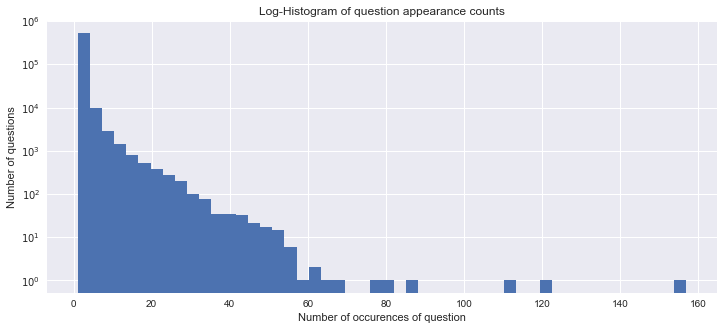

In [6]:
print('Длина выборки: {}'.format(len(data)))
print('Количество класса 1 (дубликатов в вопросах): {}%'.format(round(data['is_duplicate'].mean()*100, 2)))

qids = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
print('Всего уникальных вопросов в обучающей выборке: {}'.format(len(np.unique(qids))))
print('Количество вопросов, которые повторяются в обучении больше одного раза: {}'.format(np.sum(qids.value_counts() > 1)))

plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

Итак, меньше 100 вопросов повторяются более 30 раз

mean-train 59.86 std-train 31.99  max-train 1169.00 


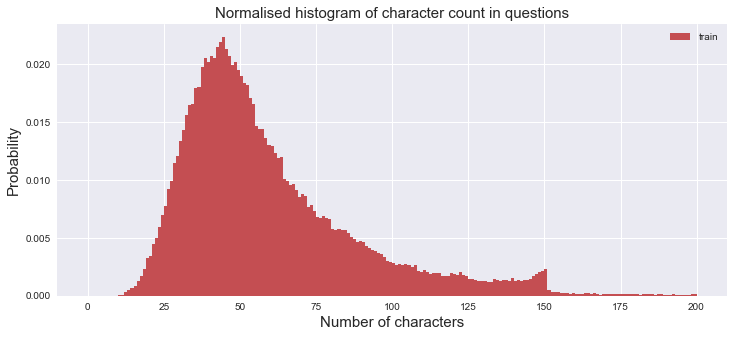

In [7]:
train_qs = pd.Series(data['question1'].tolist() + data['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
plt.figure(figsize=(12, 5))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], normed=True, label='train')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f}  max-train {:.2f} '.format(dist_train.mean(), 
                          dist_train.std(),   dist_train.max(), ))

видно, что больше всего коротких вопросов, длина которых 50 знаков. Также у Quora стоит ограничение в 150 знаков. Остальные выбросы - это из времен, когда ограничения не было

mean-train 11.06 std-train 5.89 max-train 237.00 


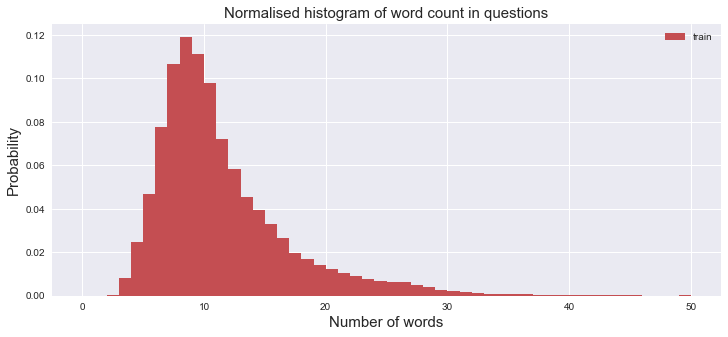

In [8]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
plt.figure(figsize=(12, 5))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], normed=True, label='train')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} max-train {:.2f} '.format(dist_train.mean(), 
                          dist_train.std(), dist_train.max()))

количество слов в вопросе по распределению сильно похоже на количество символов (что объясняется средней длиной слова). Но нет ограничения на количество слов. Распределение более сглажено с правого конца

### 2. Feature generation
Признаки, которые я хочу сгенерировать основаны на том, что необходимо выявить различия и схожесть между вопросами.
Нельзя пытаться уловить весь смысл всех сообщений, построив модель на одной такой выборке. Нужно ввести критерии схожести и различия между вопросами.

Важным фактом является то, что признаки должны быть инвариантны по отношению к перестановке двух вопросов. Например, при обработке двух вопросов они должныы быть упорядочены по определенному критерию, который заранее задан.

Предлагаемым критерием служит длина вопроса в символах. Первым вопросом считается более короткий, вторым - более длинный. Тогда для пары вопросов (q1,q2) признаковое описание будет совпадать с признаковым описанием для пары (q2,q1).

Таким образом, предлагаются в первом приближении следующие признаки:

Для символов:
- Длина 1 и 2 вопроса в символах
- Доля множества пересекающихся символов для 1 вопроса
- Доля множества символов, входящих в 1, за исключением множества пересекающихся (аналогично для 2 вопроса)

Для отдельных слов:
- Длина 1 и 2 вопроса в словах
- Доля множества пересекающихся символов для 1 вопроса
- Доля множества слов, входящих в 1, за исключением множества пересекающихся (аналогично для 2 вопроса)

Для словаря частот:
- Среднее, медианное, минимальное и максимальное значение частот слов из 1 вопроса, не входящих в пересечение

Производные функции:
- R = (len(w1 not in stops, in w2) + len(w2 not in stops, in w1))/(len(w1) + len(w2))
- То же самое для tf_idf 

Сделаем словарь частот слов

In [9]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0.
    else:
        return 1. / float(count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

Выведем наиболее популярные в употребления слова, а затем наиболее редкие

In [20]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 2.5891040146646852e-06), ('what', 3.115623919267953e-06), ('is', 3.5861702928825277e-06), ('how', 4.366449945201053e-06), ('i', 4.4805878531263305e-06), ('a', 4.540645588989843e-06), ('to', 4.671434644293609e-06), ('in', 4.884625153865692e-06), ('of', 5.920242493132519e-06), ('do', 6.070908207867897e-06)]

Least common words and weights: 

[('kernel:', 9.998000399920016e-05), ('chameleons', 9.998000399920016e-05), ('275', 9.998000399920016e-05), ('276', 9.998000399920016e-05), ('kid:', 9.998000399920016e-05), ('usenet', 9.998000399920016e-05), ('(football', 9.998000399920016e-05), ('sneha', 9.998000399920016e-05), ('population)', 9.998000399920016e-05), (',delhi', 9.998000399920016e-05)]


Видно, что наиболее редкие слова - это слова, которые смерджились со знаками препинания, опечатками, и цифры, то есть слова, употребленные случайным образом один раз во всей выборке

Выбор признаков по символам:
- Длина 1 и 2 вопроса в символах
- Доля множества пересекающихся символов для 1 вопроса
- Доля множества символов, входящих в 1, за исключением множества пересекающихся (аналогично для 2 вопроса)

In [10]:
from collections import Counter as mset

def get_features_based_on_symbols(row):
    len_1 = len(row['question1'])
    len_2 = len(row['question2'])
    if len_1 <= len_2:
        row_1 = row['question1'].lower()
        row_2 = row['question2'].lower()
    else:
        row_1 = row['question2'].lower()
        row_2 = row['question1'].lower()
    
    symbols_1 = list(row_1)
    symbols_2 = list(row_2)
    symbols_intersection = mset(symbols_1) & mset(symbols_2)
    intersection = list(symbols_intersection.elements())
    
    c = mset(list(intersection))
    c1 = mset(symbols_1)
    c2 = mset(symbols_2)
    
    diff_1 = c1 - c
    diff_2 = c2 - c
    
    uniq_1 = len(list(diff_1.elements()))/float(len_1)
    uniq_2 = len(list(diff_2.elements()))/float(len_2)
    
    uniq_symb_1_not_intercept = sum([x not in intersection for x in list(symbols_1)])/float(len_1)
    uniq_symb_2_not_intercept = sum([x not in intersection for x in list(symbols_2)])/float(len_2)
    
    return pd.Series((len_1, len_2, uniq_1, uniq_2, uniq_symb_1_not_intercept, uniq_symb_2_not_intercept))

In [11]:
data.iloc[0:10,:].apply(get_features_based_on_symbols,axis=1)

,0,1,2,3,4,5
0,66.0,57.0,0.000000,0.157895,0.000000,0.000000
1,51.0,88.0,0.039216,0.443182,0.019608,0.102273
2,73.0,59.0,0.109589,0.372881,0.041096,0.067797
3,50.0,65.0,0.340000,0.492308,0.180000,0.369231
4,76.0,39.0,0.039474,1.025641,0.013158,0.230769
5,86.0,90.0,0.116279,0.155556,0.069767,0.044444
6,19.0,62.0,0.210526,0.758065,0.210526,0.419355
7,30.0,41.0,0.066667,0.317073,0.066667,0.048780
8,35.0,37.0,0.171429,0.216216,0.171429,0.135135
9,60.0,49.0,0.133333,0.387755,0.050000,0.122449


выбор признаков по отдельным словам:
- Длина 1 и 2 вопроса в словах
- Доля множества пересекающихся символов для 1 вопроса
- Доля множества слов, входящих в 1, за исключением множества пересекающихся (аналогично для 2 вопроса)

In [12]:
def get_features_based_on_words(row):
    len_1 = len(row['question1'])
    len_2 = len(row['question2'])
    if len_1 <= len_2:
        row_1 = row['question1'].lower()
        row_2 = row['question2'].lower()
    else:
        row_1 = row['question2'].lower()
        row_2 = row['question1'].lower()
    
    words_1 = row_1.split()
    words_2 = row_2.split()
    words_intersection = mset(words_1) & mset(words_2)
    intersection = list(words_intersection.elements())
    
    c = mset(list(intersection))
    c1 = mset(list(words_1))
    c2 = mset(list(words_2))
    
    diff_1 = c1 - c
    diff_2 = c2 - c
    
    uniq_1 = len(list(diff_1.elements()))/float(len(words_1))
    uniq_2 = len(list(diff_2.elements()))/float(len(words_2))
    
    uniq_w_1_not_intercept = sum([x not in intersection for x in list(words_1)])/float(len(words_1))
    uniq_w_2_not_intercept = sum([x not in intersection for x in list(words_2)])/float(len(words_2))
    
    return pd.Series((len(words_1), len(words_2), uniq_1, uniq_2, uniq_w_1_not_intercept, uniq_w_2_not_intercept))

In [13]:
data.iloc[0:10,:].apply(get_features_based_on_words,axis=1)

,0,1,2,3,4,5
0,12.0,14.0,0.083333,0.214286,0.083333,0.142857
1,8.0,13.0,0.500000,0.692308,0.500000,0.615385
2,10.0,14.0,0.600000,0.714286,0.600000,0.714286
3,11.0,9.0,1.000000,1.000000,1.000000,1.000000
4,7.0,13.0,0.714286,0.846154,0.714286,0.846154
5,16.0,16.0,0.500000,0.500000,0.500000,0.500000
6,4.0,11.0,1.000000,1.000000,1.000000,1.000000
7,7.0,9.0,0.428571,0.555556,0.428571,0.555556
8,8.0,8.0,0.250000,0.250000,0.250000,0.250000
9,9.0,9.0,0.666667,0.666667,0.666667,0.666667


Работа над признаками, содержащими частоты слов

- Среднее, медианное, минимальное и максимальное значение частот слов из 1 вопроса, не входящих в пересечение

In [14]:
def get_features_based_on_tf_idf_words(row):
    len_1 = len(row['question1'])
    len_2 = len(row['question2'])
    if len_1 <= len_2:
        row_1 = row['question1'].lower()
        row_2 = row['question2'].lower()
    else:
        row_1 = row['question2'].lower()
        row_2 = row['question1'].lower()
    
    words_1 = row_1.split()
    words_2 = row_2.split()
    words_intersection = mset(words_1) & mset(words_2)
    intersection = list(words_intersection.elements())
    
    c = mset(list(intersection))
    c1 = mset(list(words_1))
    c2 = mset(list(words_2))
    
    diff_1 = c1 - c
    diff_2 = c2 - c
    
    uniq_1 = len(list(diff_1.elements()))/float(len(words_1))
    uniq_2 = len(list(diff_2.elements()))/float(len(words_2))
    
    uniq_w_1_not_intercept = sum([x not in intersection for x in list(words_1)])/float(len(words_1))
    uniq_w_2_not_intercept = sum([x not in intersection for x in list(words_2)])/float(len(words_2))
    
    if len([x for x in list(words_2) if x not in intersection ])!=0:
        weights_1 = [weights[w] for w in [x for x in list(words_1) if x not in intersection ]]
    else:
        weights_1 = [0]
    if len([x for x in list(words_2) if x not in intersection ])!=0:
        weights_2 = [weights[w] for w in [x for x in list(words_2) if x not in intersection ]]
    else:
        weights_2 = [0]
    try:
        mean_1 = np.mean(weights_1)
        median_1 = np.median(weights_1)
        max_1 = np.max(weights_1)
        min_1 = np.min(weights_1)
    except:
        mean_1 = 0
        median_1 = 0
        max_1 = 0
        min_1 = 0
    try:
        mean_2 = np.mean(weights_2)
        median_2 = np.median(weights_2)
        max_2 = np.max(weights_2)
        min_2 = np.min(weights_2)
    except:
        mean_2 = 0
        median_2 = 0
        max_2 = 0
        min_2 = 0
    return pd.Series((mean_1, median_1, max_1, min_1, mean_2, median_2, max_2, min_2))

In [15]:
data.iloc[0:10,:].apply(get_features_based_on_tf_idf_words, axis=1)

,0,1,2,3,4,5,6,7
0,0.000091,0.000091,0.000091,0.000091,0.000063,0.000063,0.000088,0.000038
1,0.000050,0.000048,0.000100,0.000004,0.000067,0.000073,0.000100,0.000019
2,0.000070,0.000084,0.000100,0.000019,0.000043,0.000037,0.000099,0.000003
3,0.000045,0.000044,0.000099,0.000004,0.000035,0.000028,0.000099,0.000000
4,0.000082,0.000094,0.000097,0.000030,0.000083,0.000100,0.000100,0.000007
5,0.000058,0.000069,0.000100,0.000000,0.000052,0.000053,0.000100,0.000000
6,0.000022,0.000012,0.000061,0.000000,0.000052,0.000067,0.000097,0.000000
7,0.000014,0.000008,0.000030,0.000004,0.000023,0.000006,0.000080,0.000003
8,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100
9,0.000030,0.000008,0.000092,0.000000,0.000037,0.000010,0.000100,0.000000


Теперь заполним все пропущенные значения нулями и применим полученные преобразования

In [17]:
data_2 = data.fillna('zero')

In [18]:
X = pd.concat((
    data_2.apply(get_features_based_on_symbols,axis=1),
    data_2.apply(get_features_based_on_words,axis=1),
    data_2.apply(get_features_based_on_tf_idf_words, axis=1)
        ),axis=1)

C:\Users\agoncharov\Anaconda2\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Users\agoncharov\Anaconda2\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Переименуем все значения в интерпретируемые

In [19]:
X.columns = ['len_1', 'len_2', 'uniq_1_s', 'uniq_2_s', 'uniq_symb_1_not_intercept', 'uniq_symb_2_not_intercept', 
            'len(words_1)', 'len(words_2)', 'uniq_1_w', 'uniq_2_w', 'uniq_w_1_not_intercept', 'uniq_w_2_not_intercept',
            'mean_1', 'median_1', 'max_1', 'min_1', 'mean_2', 'median_2', 'max_2', 'min_2']

In [20]:
X.head()

,len_1,len_2,uniq_1_s,uniq_2_s,uniq_symb_1_not_intercept,uniq_symb_2_not_intercept,len(words_1),len(words_2),uniq_1_w,uniq_2_w,uniq_w_1_not_intercept,uniq_w_2_not_intercept,mean_1,median_1,max_1,min_1,mean_2,median_2,max_2,min_2
0,66.0,57.0,0.000000,0.157895,0.000000,0.000000,12.0,14.0,0.083333,0.214286,0.083333,0.142857,0.000091,0.000091,0.000091,0.000091,0.000063,0.000063,0.000088,0.000038
1,51.0,88.0,0.039216,0.443182,0.019608,0.102273,8.0,13.0,0.500000,0.692308,0.500000,0.615385,0.000050,0.000048,0.000100,0.000004,0.000067,0.000073,0.000100,0.000019
2,73.0,59.0,0.109589,0.372881,0.041096,0.067797,10.0,14.0,0.600000,0.714286,0.600000,0.714286,0.000070,0.000084,0.000100,0.000019,0.000043,0.000037,0.000099,0.000003
3,50.0,65.0,0.340000,0.492308,0.180000,0.369231,11.0,9.0,1.000000,1.000000,1.000000,1.000000,0.000045,0.000044,0.000099,0.000004,0.000035,0.000028,0.000099,0.000000
4,76.0,39.0,0.039474,1.025641,0.013158,0.230769,7.0,13.0,0.714286,0.846154,0.714286,0.846154,0.000082,0.000094,0.000097,0.000030,0.000083,0.000100,0.000100,0.000007


Добавим дополнительные hacks из kaggle kernels, у которых хорошие отзывы

In [32]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/float(len(q1words) + len(q2words))
    return R


def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / float(np.sum(total_weights))
    return R

In [33]:
train_word_match = data.apply(word_match_share, axis=1, raw=True)
tfidf_train_word_match = data.apply(tfidf_word_match_share, axis=1, raw=True)

C:\Users\agoncharov\Anaconda2\lib\site-packages\ipykernel\__main__.py:39: RuntimeWarning: invalid value encountered in double_scalars


In [34]:
X_additional = pd.concat((
                    X,
                    train_word_match,
                    tfidf_train_word_match
                        ),axis=1)


In [35]:
y = data['is_duplicate'].values

In [36]:
X_additional = X_additional.fillna(0)

### Классификация по полученным признакам

Для начала нормируем все значения на 0 - 1

In [37]:
from sklearn.preprocessing import MinMaxScaler

X_norm = MinMaxScaler().fit_transform(X_additional)

Разделим всю выборку на обучение и контроль. В соотношении 3:7

In [38]:
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(X_norm, y, test_size=0.3, random_state=4242)

Произведем классификацию при помощи различных классификаторов:

#### XGBoost
Вычисления производились на рабочей машине, где стоит windows, так что данный ноутбук без данного раздела

In [39]:
#import xgboost as xgb
# # Set our parameters for xgboost
#params = {}
#params['objective'] = 'binary:logistic'
#params['eval_metric'] = 'logloss'
#params['eta'] = 0.02
#params['max_depth'] = 4

#d_train = xgb.DMatrix(x_train, label=y_train)
#d_valid = xgb.DMatrix(x_valid, label=y_valid)

#watchlist = [(d_train, 'train'), (d_valid, 'valid')]

#bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

#### RandomForest

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

clf = RandomForestClassifier()
clf.fit(x_train, y_train)
y_pred_proba = clf.predict_proba(x_valid)
y_pred = clf.predict(x_valid)

In [73]:
y_pred_2 = y_pred.copy()+0.
alpha = 0.2
y_pred_2[y_pred_2 < alpha] = alpha
y_pred_2[y_pred_2 > 1-alpha] = 1-alpha

In [75]:
print accuracy_score(y_valid,y_pred)
print log_loss(y_valid,y_pred_proba)
print log_loss(y_valid,y_pred_2)

0.769010693644
0.625735594681
0.543362724195


#### Logistic Regression

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split

clf = LogisticRegression()
grid = {
    'C': [1e-6, 1e-3, 1e0],
    'penalty': ['l1', 'l2']
}
cv = GridSearchCV(clf, grid, scoring='neg_log_loss', n_jobs=-1, verbose=1)
cv.fit(X_norm, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.3min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [1e-06, 0.001, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=1)

In [78]:
for i in range(1, len(cv.cv_results_['params'])+1):
    rank = cv.cv_results_['rank_test_score'][i-1]
    s = cv.cv_results_['mean_test_score'][i-1]
    sd = cv.cv_results_['std_test_score'][i-1]
    params = cv.cv_results_['params'][i-1]
    print("{0}. Mean validation neg log loss: {1:.3f} (std: {2:.3f}) - {3}".format(
        rank,
        s,
        sd,
        params
    ))

6. Mean validation neg log loss: -0.693 (std: 0.000) - {'penalty': 'l1', 'C': 1e-06}
5. Mean validation neg log loss: -0.666 (std: 0.000) - {'penalty': 'l2', 'C': 1e-06}
4. Mean validation neg log loss: -0.533 (std: 0.001) - {'penalty': 'l1', 'C': 0.001}
3. Mean validation neg log loss: -0.532 (std: 0.001) - {'penalty': 'l2', 'C': 0.001}
1. Mean validation neg log loss: -0.513 (std: 0.001) - {'penalty': 'l1', 'C': 1.0}
2. Mean validation neg log loss: -0.515 (std: 0.001) - {'penalty': 'l2', 'C': 1.0}


### Выводы

Таким образом, достигнут плохой результат качества, судя по Leader Board. Применение XGBoost Позволит увеличить это качество на 0.1 - 0.2, что выведет результат в середину списка.

Были попробованы различные методы выбора признаков.
На мой взгляд, их качество достаточно хорошее, но необходимо улучшить предобработку вопросов. Сейчас вся предобработка заключается в приведении к нижнему регистру. Нужно сделать лемматизацию или стемминг, хорошее удаление стоп-слов, можно использовать словари синонимов, что является лучшим решением для данной задачи.